In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')
!ls

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
fdcf55fd5bab0f67.jpg			   model_xception.h5
model18classes_dropout.h5		   S__5234699.jpg
model18classes.h5			   test
model18classes_opt.h5			   train
model18classes_xception_finetune1block.h5  validation
model18classes_xception.h5		   vegs.h5
model_test.tflite			   vegs.tflite


In [ ]:
cd ./gdrive/My Drive/Dataset

[Errno 2] No such file or directory: './gdrive/My Drive/Dataset'
/content/gdrive/.shortcut-targets-by-id/1nbrYFLfLz6JjZFXeECNAQEKgU5ZSyOpe/Dataset


In [ ]:
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

TRAINING_DIR = "train/"
training_datagen = ImageDataGenerator(
      rescale = 1.0/255.)

VALIDATION_DIR = "validation/"
validation_datagen = ImageDataGenerator(rescale = 1.0/255.)

train_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(299,299),
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(299,299),
    class_mode='categorical'
)

Found 6620 images belonging to 18 classes.
Found 649 images belonging to 18 classes.


In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Pretrained Model + Fine Tuning (https://keras.io/api/applications/)
# create the base pre-trained model : Xception + global spatial average pooling
base_model = Xception(weights='imagenet', input_shape = (299,299,3), include_top=False, pooling = 'avg')

# add a global spatial average pooling layer
x = base_model.output
# let's add a fully-connected layer
x = Dense(256, activation='relu')(x)
# and a logistic layer -- 18 classes
predictions = Dense(18, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
opt = Adam(lr=0.001, decay = 1e-6, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics = ['accuracy'])

# train the model on the new data for a few epochs
model.fit(train_generator, epochs=4, validation_data = validation_generator, verbose = 1)

# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from Xception. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

# we chose to train the last inception blocks, i.e. we will freeze
# the first 125 layers and unfreeze the rest:
for layer in model.layers[:125]:
    layer.trainable = False
for layer in model.layers[125:]:
    layer.trainable = True
# we need to recompile the model for these modifications to take effect
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics = ['accuracy'])

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
history = model.fit(train_generator, epochs=4, validation_data = validation_generator, verbose = 1)

Epoch 1/4
207/207 [==============================] - 151s 729ms/step - loss: 1.0579 - accuracy: 0.6870 - val_loss: 0.6372 - val_accuracy: 0.8120
Epoch 2/4
207/207 [==============================] - 149s 720ms/step - loss: 0.6782 - accuracy: 0.7810 - val_loss: 0.6198 - val_accuracy: 0.8336
Epoch 3/4
207/207 [==============================] - 147s 708ms/step - loss: 0.5459 - accuracy: 0.8264 - val_loss: 0.6283 - val_accuracy: 0.8166
Epoch 4/4
207/207 [==============================] - 145s 700ms/step - loss: 0.4547 - accuracy: 0.8521 - val_loss: 0.6895 - val_accuracy: 0.8166
0 input_2
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_4
13 block2_pool
14 batch_normalization_4
15 add_12
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_5
23

In [ ]:
model.save("model_xception_v2.h5")

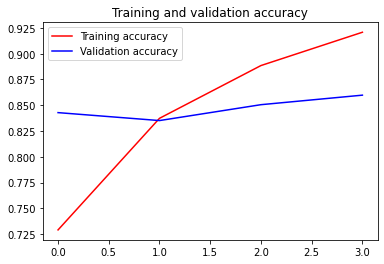

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

Saving 3c830c1e56edd476.jpg to 3c830c1e56edd476.jpg


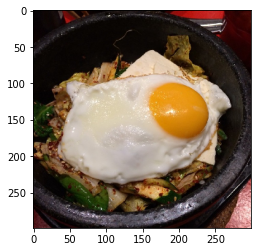

Banana: 0.00%
Cabbage: 0.01%
Cucumber: 0.00%
Egg: 99.92%
Fish: 0.00%
Grape: 0.00%
Lemon: 0.00%
Milk: 0.00%
Mushroom: 0.00%
Pasta: 0.00%
Shrimp: 0.00%
Squid: 0.00%
Strawberry: 0.00%
broccoli: 0.00%
carrot: 0.00%
cheese: 0.02%
potato: 0.01%
tomato: 0.05%


In [ ]:
import numpy as np
from google.colab import files
from tensorflow.keras.applications.xception import preprocess_input

labels = train_generator.class_indices.keys()

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(299, 299))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  images = np.vstack([x])
  proba = model.predict(images)[0]
  plt.imshow(img)
  plt.show()
  for (label, p) in zip(labels, proba):
    print("{}: {:.2f}%".format(label, p * 100))

In [ ]:
import tensorflow as tf

# Load the model.
new_model= tf.keras.models.load_model(filepath="model_xception_v2.h5")

# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(new_model)
tflite_model = converter.convert()

# Save the TF Lite model.
with tf.io.gfile.GFile('model_xception_v2.tflite', 'wb') as f:
  f.write(tflite_model)